In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls "/gdrive/My Drive/bigcontest2019/data/" # address of our files

ls: cannot access '/gdrive/My Drive/bigcontest2019/data/': No such file or directory


In [0]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (15, 8)

In [22]:
path = '/gdrive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'train'),'\n')

FileNotFoundError: ignored

In [0]:
train_label = pd.read_csv(path+'train/'+'train_label.csv')
train_activity = pd.read_csv(path+'train/'+'train_activity.csv')

- 유저 특성 나눌 수 있는 기준들
  * 주말만 / 주중만 / 상관없이 플레이
  * 신규유저 / 기존유저
  * 돈 많이 / 돈 적게 (정기 패키지 정도만) / 돈 안 쓴 유저
  * 사냥형 / 상점형 / 낚시형 / ...
  * 플레이 시간이 긴 열혈유저 / 일반유저 / 깨작깨작 하는 유저
  
- exp 관련 고려사항
  * 지난 1주일 얻은 경험치 대비 경험치 수치 (고렙일수록 경험치 획득량이 높지만 무의미하기 때문에)

# Train Data

In [36]:
train_label.shape

(40000, 3)

In [37]:
train_label.head()

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396


In [38]:
train_label.loc[train_label['acc_id']==31]

,acc_id,survival_time,amount_spent
15073,31,45,0.051316


|변수 | 변수 설명|
|-- | --|
|acc_id | 유저 아이디|
|survival_time | 생존 기간(일)|
|amount_spent | 일별 평균 결제 금액|

In [0]:
train_activity.shape

(1601834, 17)

In [0]:
train_activity.head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,75001,397380,aa,1.441844,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,1.10514,0.034006,0.0
1,1,75001,216231,aa,0.283219,2.247978,0.047085,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,-0.013963,0.0
2,1,75711,308769,aa,1.036910,2.956638,0.321821,0.166593,0.003470,1,0.245883,0.247337,0.0,0.0,0.00000,-0.001987,0.0
3,1,72230,387177,aa,0.229384,4.042102,0.099147,0.000000,0.001735,0,0.000000,0.000000,0.0,0.0,0.00000,-0.028884,0.0
4,1,34253,339862,aa,1.088405,0.596802,0.003377,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,0.011777,0.0


변수 | 변수 설명
------ | --------
day | 날짜
acc_id | 유저 아이디
char_id | 캐릭터 아이디
server | 캐릭터 서버
playtime | 일일 플레이시간
npc_kill npc | npc를 죽인 횟수
solo_exp | 솔로 사냥 획득 경험치
party_exp | 파티 사냥 획득 경험치
quest_exp | 퀘스트 획득 경험치
boss_monster | 보스 몬스터 타격 여부 (0=미타격 ,1= 타격)
death | 캐릭터 사망 횟수
revive | 부활 횟수
exp_recovery | 경험치 복구 횟수(성당)
fishing | 일일 낚시 시간
private_shop | 일일 개인상점 운영 시간
game_money_change | 일일 아데나 변동량
enchant_count | 7 레벨 이상 아이템 인첸트 시도 횟수


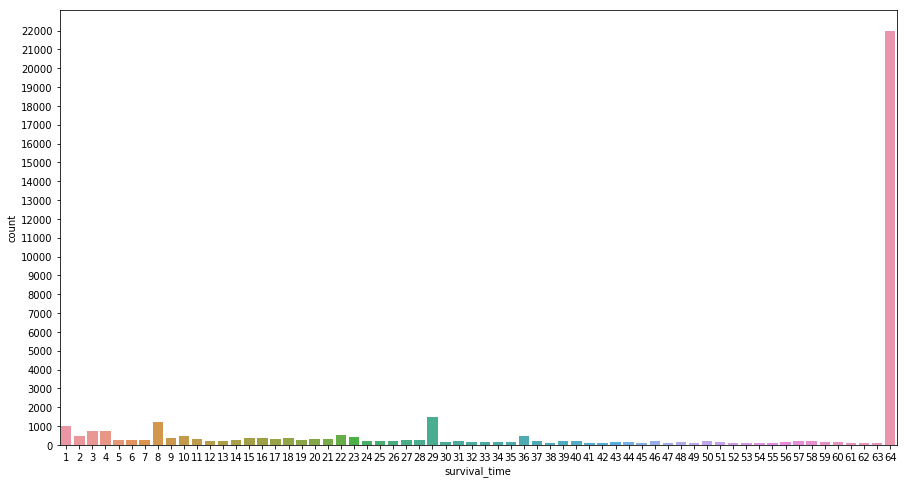

In [0]:
sns.countplot(x='survival_time', data = train_label)
plt.yticks(np.arange(0, max(train_label['survival_time'].value_counts())+1000, 1000))
plt.show()

In [0]:
train_label['survive'] = train_label.survival_time.apply(lambda x: 'long_survive' if x >= 64 else 'short_survive')
train_label.head()

,acc_id,survival_time,amount_spent,survive
0,27835,64,0.002559,long_survive
1,12351,64,0.120154,long_survive
2,125437,55,0.182593,short_survive
3,104483,64,0.016241,long_survive
4,4704,20,0.226396,short_survive


In [0]:
train_label.survive.value_counts()

long_survive     21996
short_survive    18004
Name: survive, dtype: int64

- 64일 생존자 (확실한 생존자)가 압도적으로 많다
- 64일 생존과 나머지로 나눴을 때 64일 생존 21996명, 나머지 18004명

## 신규 유저 체크

In [0]:
new_temp = train_activity.groupby(['acc_id', 'day']).count()['char_id'].reset_index()
new_temp.head()

,acc_id,day,char_id
0,2,1,1
1,2,2,1
2,2,3,1
3,2,4,1
4,2,5,1


In [0]:
new_temp = new_temp.rename(columns={"char_id":"active"})

In [0]:
new_temp['active'] = 1

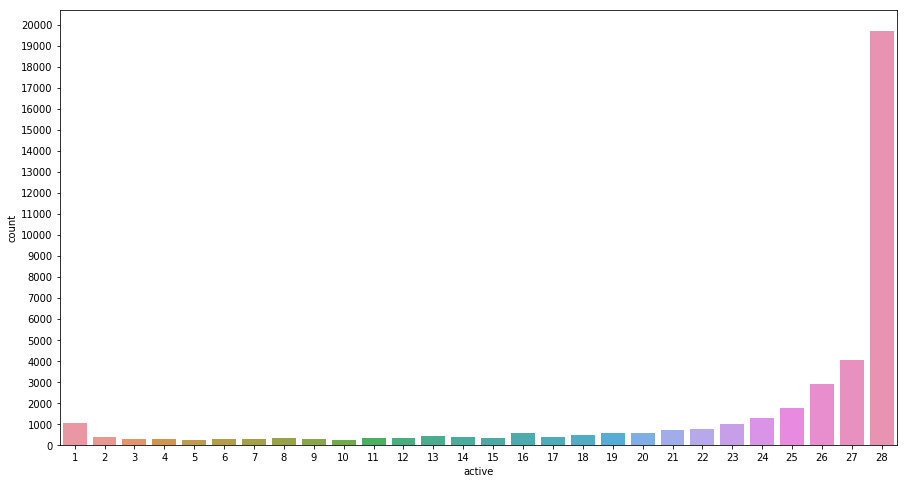

In [0]:
sns.countplot(x='active', data=new_temp.groupby('acc_id').sum().reset_index())
plt.yticks(np.arange(0, 20001, 1000))
plt.show()

- 대부분 28일 접속하고, 25일 이상 접속이 굉장히 많다

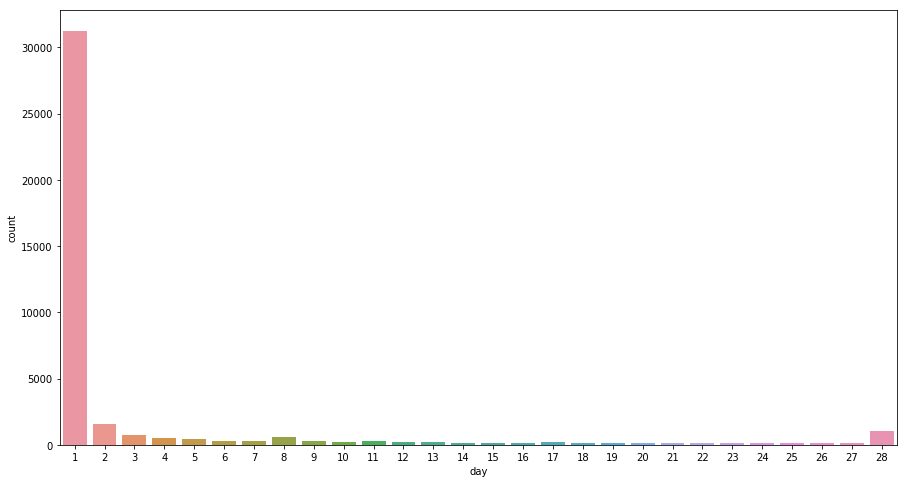

In [0]:
sns.countplot(x='day', data=new_temp.groupby('acc_id').min())
plt.show()

- 대부분 1일부터 접속했다. 이 게임은 조금씩해도 꾸준히 하는 게임인듯...
- 나머지는 비율이 그만그만해서 7~10 정도 중에 잡고 그 이후 게임 시작한 유저는 신규유저로 봐도 될 듯

In [0]:
new_user = new_temp.groupby('acc_id').min()['day'].reset_index()

In [0]:
n_for_new = 7

In [0]:
new_user['newold'] = new_temp.groupby('acc_id').min()['day'].reset_index()['day'].apply(lambda x: 'new' if x >= n_for_new else 'old')
new_user.head()

,acc_id,day,newold
0,2,1,old
1,5,9,new
2,8,1,old
3,17,1,old
4,20,1,old


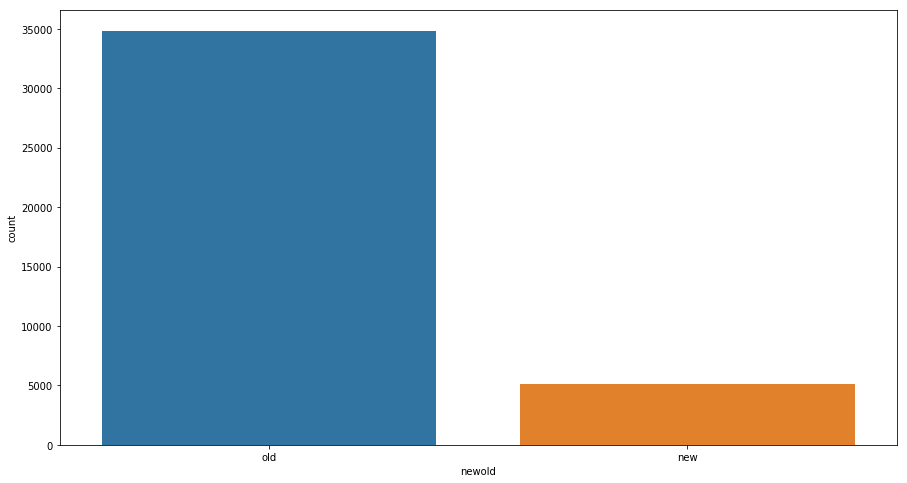

In [0]:
sns.countplot(x='newold', data=new_user)
plt.show()

## 돈 액수가 대략 어느정도인지 체크

In [0]:
np.round(train_label['amount_spent']*train_label['survival_time'], 5).value_counts()[np.round(train_label['amount_spent']*train_label['survival_time'], 5).value_counts()>30] # 제대로 즐기기 위해 필요한 최소 금액에 대해 생각해봐야 함

0.00000    16438
2.30990      756
0.97436      558
1.94871      508
0.06510      270
0.97449      231
0.09870      156
0.09843      144
1.94898      106
0.06562      104
2.37499       94
2.01381       93
0.98486       88
1.47623       79
0.32549       79
2.95299       78
2.92307       74
0.32483       68
1.03945       68
1.07292       67
0.98433       64
2.95247       63
0.19739       61
0.32759       56
0.74809       55
1.47650       54
3.28425       52
0.16379       52
1.59462       51
0.97429       47
4.61980       45
1.49618       39
1.96971       39
2.93357       39
3.29475       38
0.06556       36
0.06569       35
0.09853       35
2.04741       33
1.64003       32
dtype: int64

In [0]:
np.quantile(train_label['amount_spent']*train_label['survival_time'], [0.1*x for x in range(11)])

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.97435691,  1.94871382,  3.23362732,  6.57522923, 13.2155359 ,
       97.51548768])

In [0]:
train_label.iloc[16914]

acc_id                  30740
survival_time              64
amount_spent          1.52368
survive          long_survive
Name: 16914, dtype: object

In [0]:
1.52368*65

99.0392

In [0]:
train_label['amount_spent'][train_label['amount_spent']*train_label['survival_time'] == 0.035204]

Series([], Name: amount_spent, dtype: float64)

## EDA

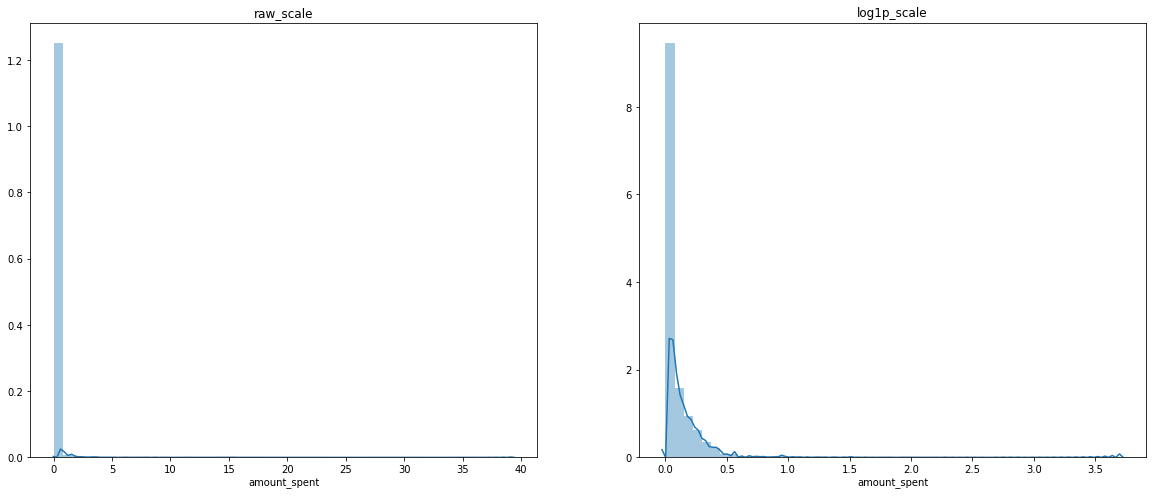

In [0]:
plt.figure(figsize = (20, 8))

plt.subplot(1,2,1)
sns.distplot(train_label['amount_spent'])
plt.title('raw_scale')

plt.subplot(1,2,2)
sns.distplot(np.log1p(train_label['amount_spent']))# np.log1p
plt.title('log1p_scale')
plt.show()

In [0]:
train_label.amount_spent[train_label.amount_spent==0].count()

16438

In [0]:
train_label.amount_spent[train_label.amount_spent!=0].count()

23562

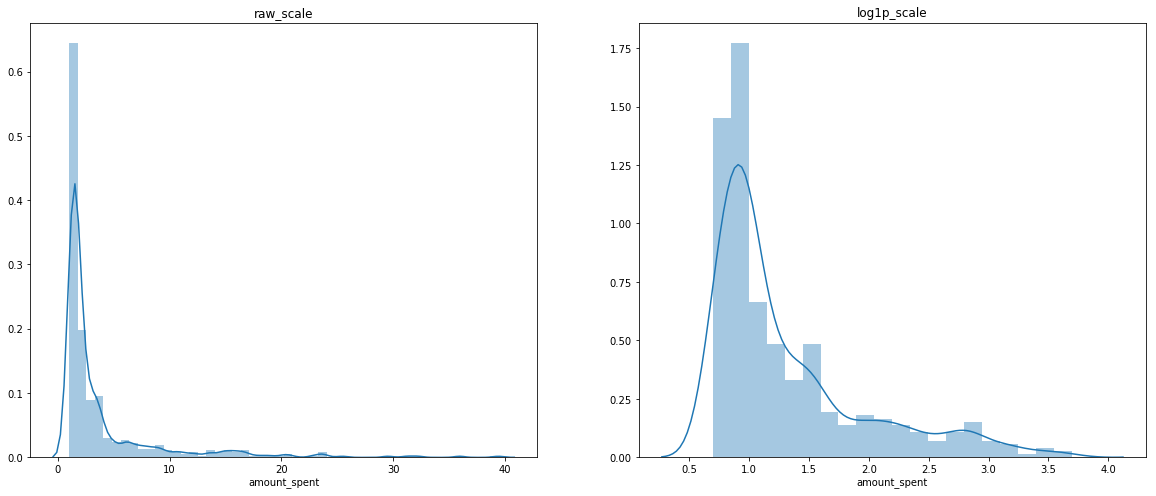

In [0]:
plt.figure(figsize = (20, 8))

plt.subplot(1,2,1)
sns.distplot(train_label.amount_spent[train_label.amount_spent >= 1])
plt.title('raw_scale')

plt.subplot(1,2,2)
sns.distplot(np.log1p(train_label.amount_spent[train_label.amount_spent >= 1]))
plt.title('log1p_scale')

plt.show()

- amount_spent는 0이 16438명이나 되고, 최소한 1원이라도 사용한 사람은 23562명이다
- 그리고 사용 액수는 exponetial하게 감소하는 추세이기 때문에 대부분 0원에 있다
- 돈을 아예 안 쓴 사람들을 별도로 떼어내서 특징이 될 요소들을 찾으면, 그걸로 집단을 둘로 나눌 수 있을 것 같다

In [0]:
train_label['spent'] = train_label.amount_spent.apply(lambda x: 'zero' if x == 0 else 'not_zero')
train_label.head()

,acc_id,survival_time,amount_spent,survive,spent
0,27835,64,0.002559,long_survive,not_zero
1,12351,64,0.120154,long_survive,not_zero
2,125437,55,0.182593,short_survive,not_zero
3,104483,64,0.016241,long_survive,not_zero
4,4704,20,0.226396,short_survive,not_zero


In [0]:
pd.crosstab(train_label['survive'], train_label['spent'], margins=True)

spent,not_zero,zero,All
survive,,,
long_survive,14635,7361,21996
short_survive,8927,9077,18004
All,23562,16438,40000


In [0]:
pd.crosstab(train_label['survive'], train_label['spent'], margins=True, normalize='columns')

spent,not_zero,zero,All
survive,,,
long_survive,0.621127,0.447804,0.5499
short_survive,0.378873,0.552196,0.4501


In [0]:
pd.crosstab(train_label['survive'], train_label['spent'], margins=True, normalize='index')

spent,not_zero,zero
survive,,
long_survive,0.665348,0.334652
short_survive,0.495834,0.504166
All,0.589050,0.410950


<Figure size 1152x1152 with 0 Axes>

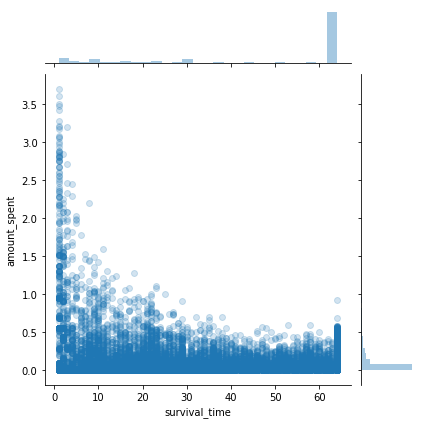

In [0]:
plt.figure(figsize = (16, 16))
sns.jointplot(train_label['survival_time'], np.log1p(train_label['amount_spent']), alpha=0.2)
plt.show()

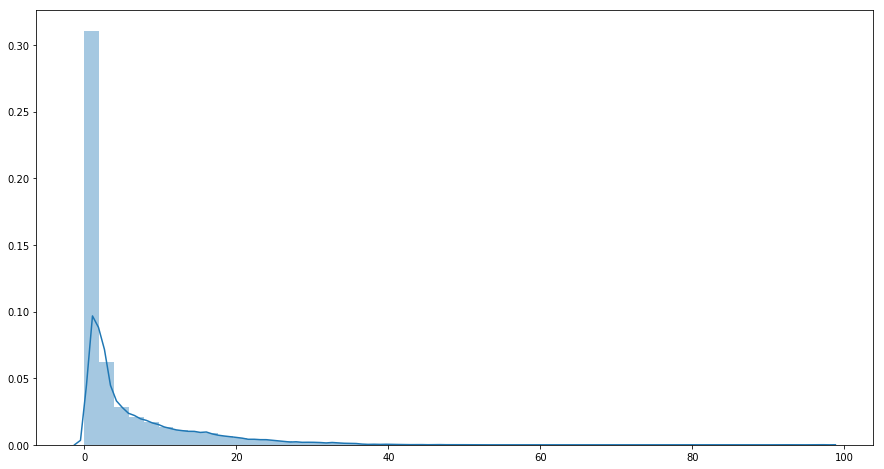

In [0]:
sns.distplot(train_label['survival_time']*(train_label['amount_spent']))
plt.show()

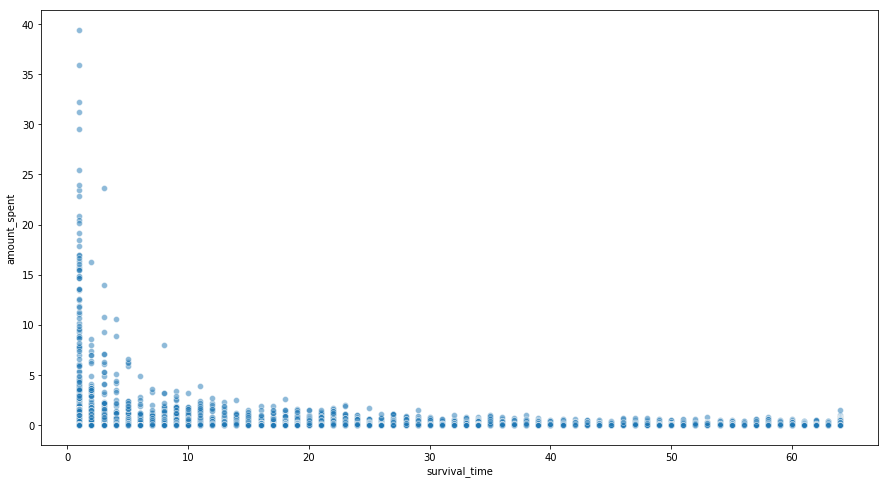

In [0]:
sns.scatterplot(train_label['survival_time'], (train_label['amount_spent']), alpha=0.5)
plt.show()

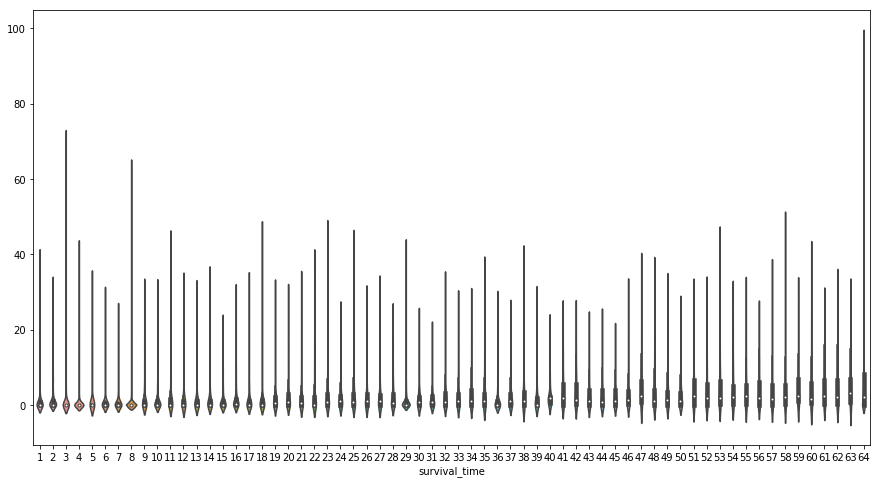

In [0]:
sns.violinplot(train_label['survival_time'], (train_label['amount_spent']*train_label['survival_time']))
plt.show()

- 나이브하게 말하면 돈 쓴 사람은 생존 가능성 높고, 생존한 사람은 돈을 0원 이상 썼을 가능성이 높다
- survival time이 0에 가까운 사람들이 돈 쓴 액수가 높은 경우 많다?
  - 가설 1) 초보자들이 뭣도 모르고 돈을 탕진했다가 이건 아니다 싶어서 나갔다
  - 가설 2) 현질로 쎄지는 거 좋아하는 유저들이 유입되었다가 잠깐 즐기고 다른 게임에 돈 쓰러 갔다
  - 가설 3) 돈을 많이 써서 강해지려고 했는데 뜻대로 되지 않아서 (강화 실패 등) 접었다
 - survival time 0일 때 돈 쓴 액수 많은 이유는 일 평균 사용 금액이기 때문으로 밝혀져... 그래도 하루 정도만에 많은 양을 한 번에 썼다는 의미이긴 하니까 이런 것의 의미를 파악하면 좋겠다

In [0]:
train_server = train_activity.groupby(['server', 'char_id']).count()['day'].reset_index().rename(columns={'day':'exist'})

In [0]:
train_server['exist']=1

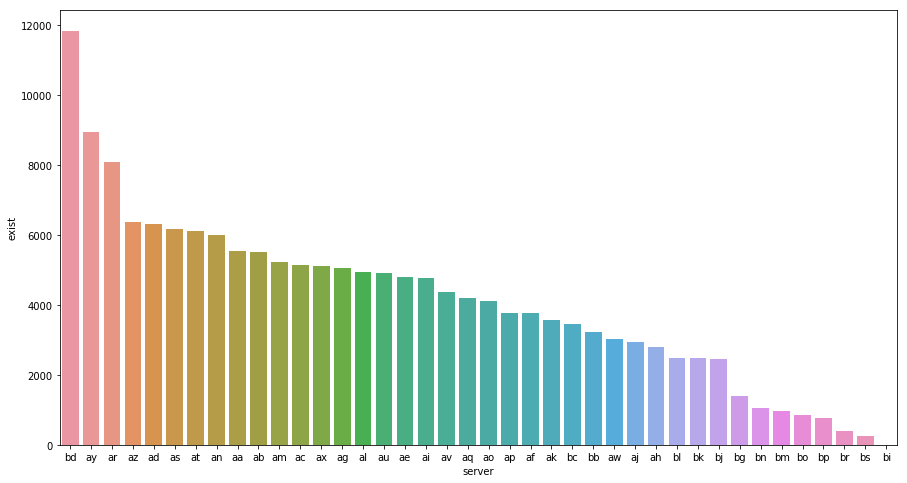

In [0]:
sns.barplot(x='server', y='exist', data=train_server.groupby('server').count().reset_index(), 
            order=train_server.groupby('server').count().reset_index().sort_values(by='exist', ascending=False)['server'])
plt.show()

- 주류 서버와 아닌 서버가 있다
- 차이까지는...

In [0]:
activity_summary_label = pd.merge(train_activity.drop(['char_id', 'server'], axis=1).groupby(['acc_id', 'day']).sum().reset_index(), train_label, on = 'acc_id', how='left')
activity_summary_label.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survival_time,amount_spent,survive,spent
0,2,1,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0,64,0.0,long_survive,zero
1,2,2,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0,64,0.0,long_survive,zero
2,2,3,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0,64,0.0,long_survive,zero
3,2,4,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0,64,0.0,long_survive,zero
4,2,5,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0,64,0.0,long_survive,zero


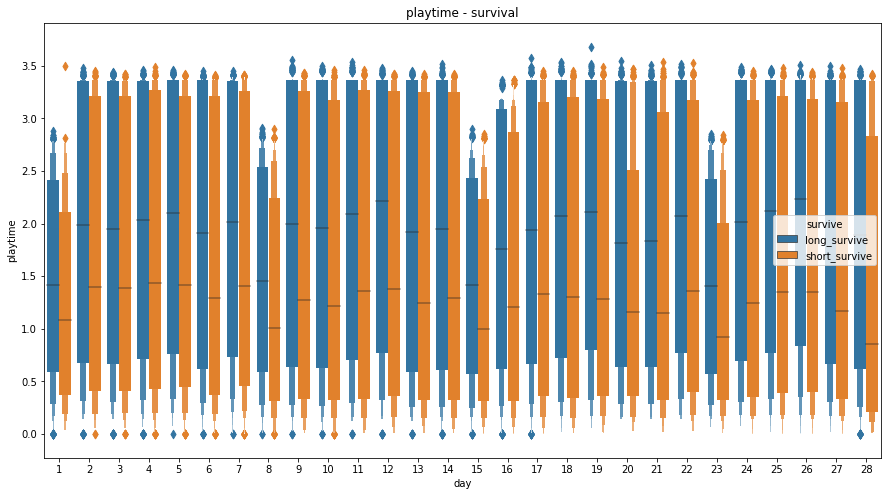

In [0]:
sns.boxenplot(x='day', y= 'playtime', hue='survive', data=activity_summary_label)
plt.title('playtime - survival')
plt.show()

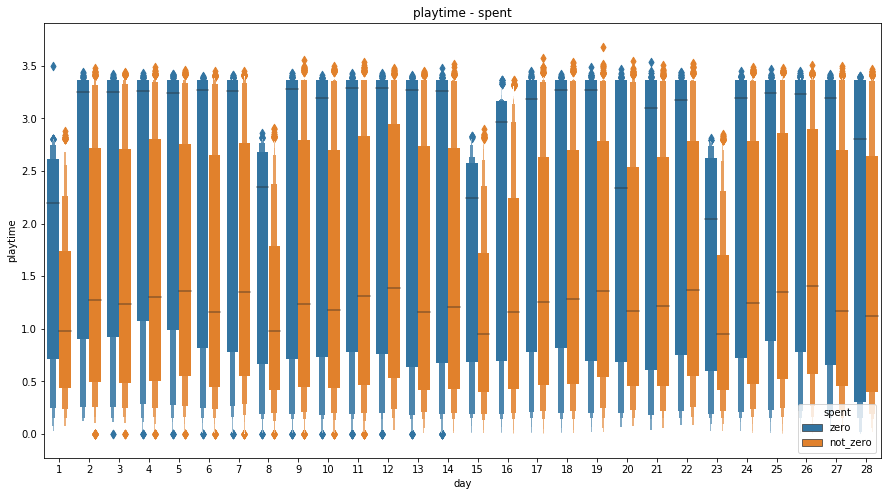

In [0]:
sns.boxenplot(x='day', y= 'playtime', hue='spent', data=activity_summary_label)
plt.title('playtime - spent')
plt.show()

- 7일 주기로 playtime이 줄어드는데 이유가 뭘까?
- label에서 64일 이상 접속한 집단이  playtime 조금씩 더 길다
- 일별로 하드하게 하는 소수 제외하면 대체적으로 돈 안 쓴 사람들이 플레이시간 더 길다

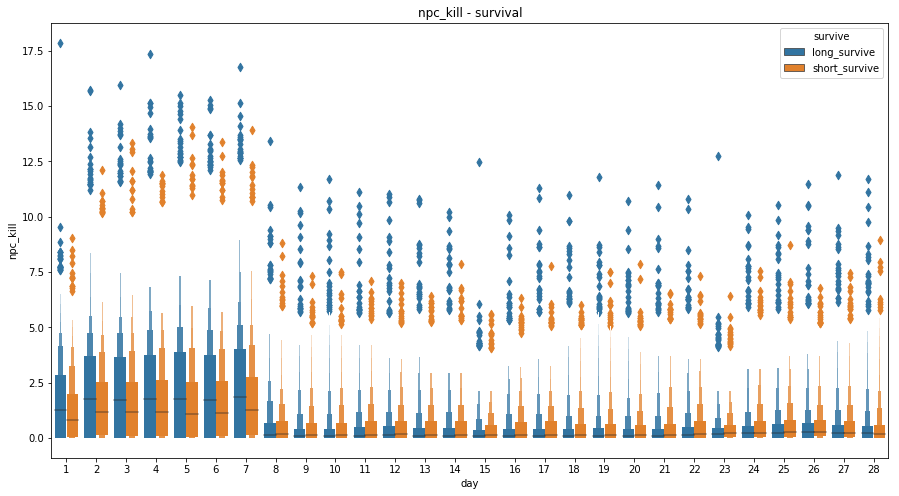

In [0]:
sns.boxenplot(x='day', y= 'npc_kill', hue='survive', data=activity_summary_label)
plt.title('npc_kill - survival')
plt.show()

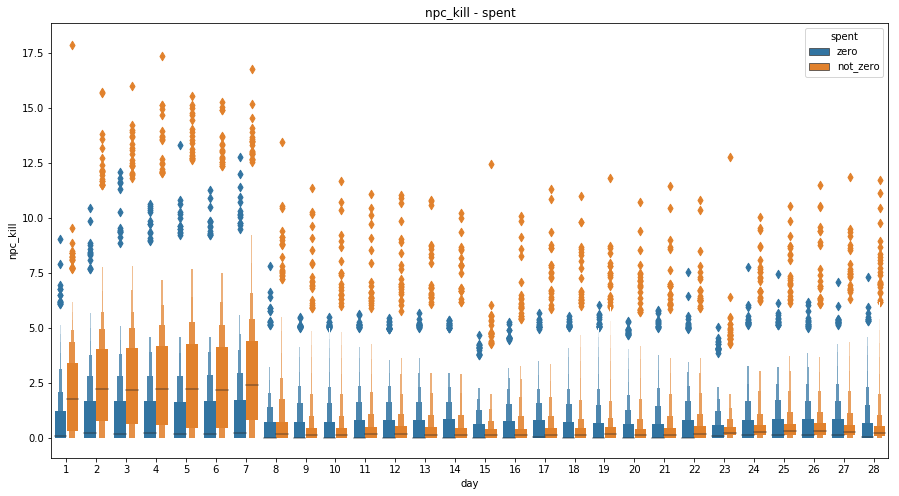

In [0]:
sns.boxenplot(x='day', y= 'npc_kill', hue='spent', data=activity_summary_label)
plt.title('npc_kill - spent')
plt.show()

- npc를 처음 6일 정도 많이 잡았는데 이벤트가 있었던건가?
- npc_kill도 64일 이상 접속자가 더 많이 하는 듯? (확실 X)
- 돈 쓴 사람들이 npc_kill 더 많이 한다

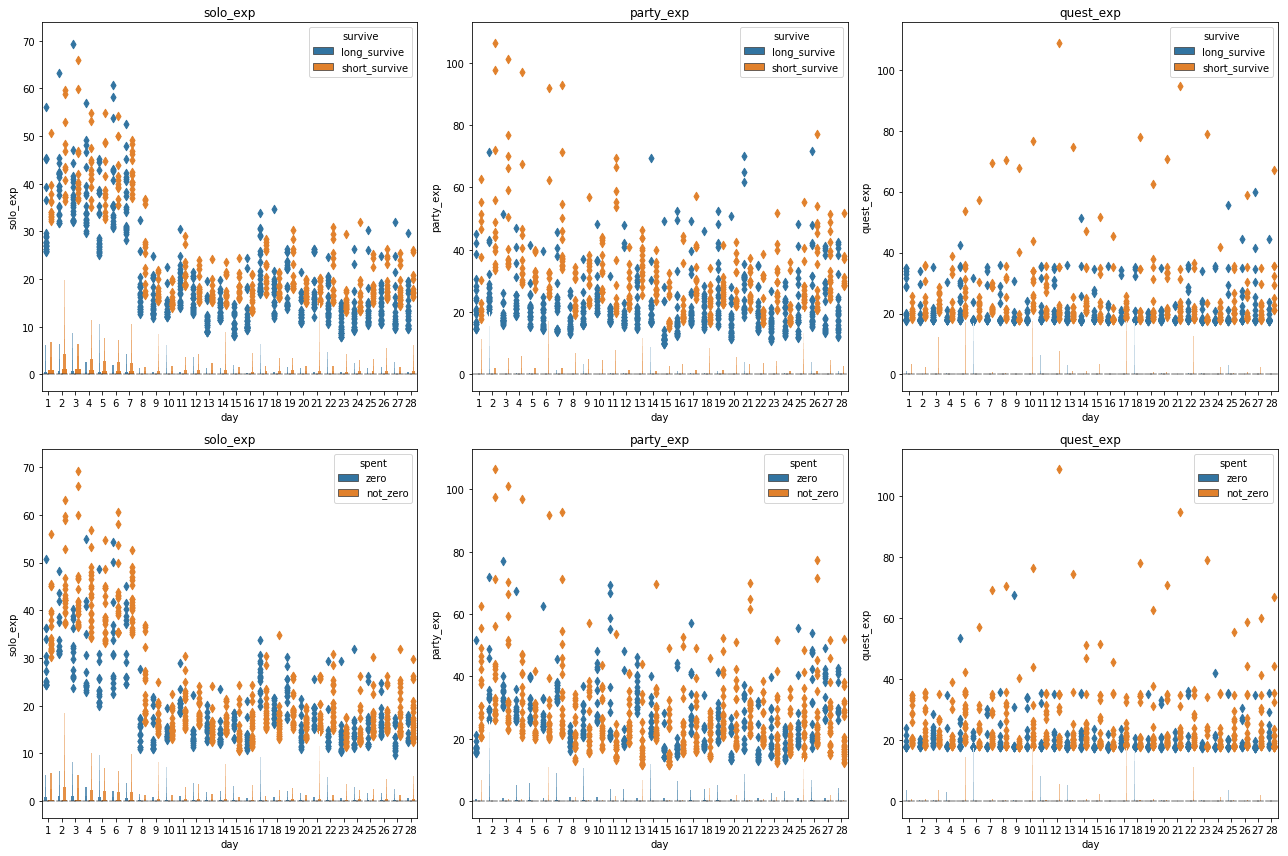

In [0]:
plt.figure(figsize = (18, 12))

plt.subplot(2,3,1)
sns.boxenplot(x='day', y= 'solo_exp', hue='survive', data=activity_summary_label)
plt.title('solo_exp')

plt.subplot(2,3,2)
sns.boxenplot(x='day', y= 'party_exp', hue='survive', data=activity_summary_label)
plt.title('party_exp')

plt.subplot(2,3,3)
sns.boxenplot(x='day', y= 'quest_exp', hue='survive', data=activity_summary_label)
plt.title('quest_exp')

plt.subplot(2,3,4)
sns.boxenplot(x='day', y= 'solo_exp', hue='spent', data=activity_summary_label)
plt.title('solo_exp')

plt.subplot(2,3,5)
sns.boxenplot(x='day', y= 'party_exp', hue='spent', data=activity_summary_label)
plt.title('party_exp')

plt.subplot(2,3,6)
sns.boxenplot(x='day', y= 'quest_exp', hue='spent', data=activity_summary_label)
plt.title('quest_exp')

plt.tight_layout()
plt.show()

- solo_exp만 보면 처음 6일 정도 무슨 이벤트가 있었던 듯
- 파티 통한 경험치 획득이 많은 편 > 퀘스트 > 솔로
- 파티, 퀘스트 경험치 기준으로 이례적으로 많은 경험치 얻은 애들은 대부분 '이탈-돈 씀' 조합이였다

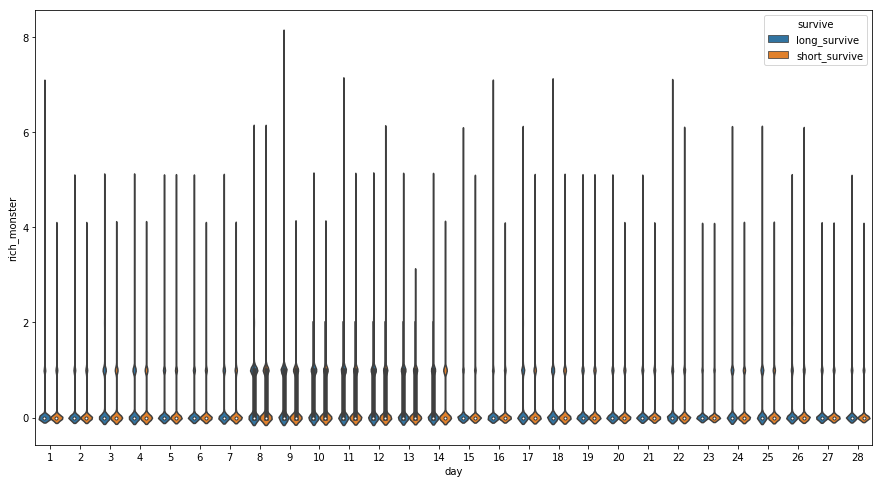

In [0]:
sns.violinplot(x='day', y= 'rich_monster', hue='survive', data=activity_summary_label)
plt.show()

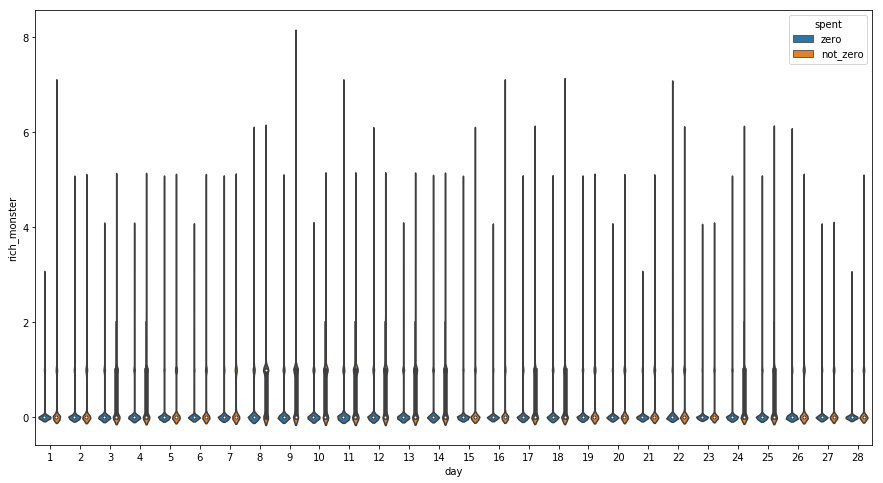

In [0]:
sns.violinplot(x='day', y= 'rich_monster', hue='spent', data=activity_summary_label)
plt.show()

- 대게 rich monster는 안 잡는다. 8~14까지는 조금 잡았다.
- 64일 이상 접속한 그룹이 아닌 그룹보다는 더 많이 사냥하는 경향성 있음

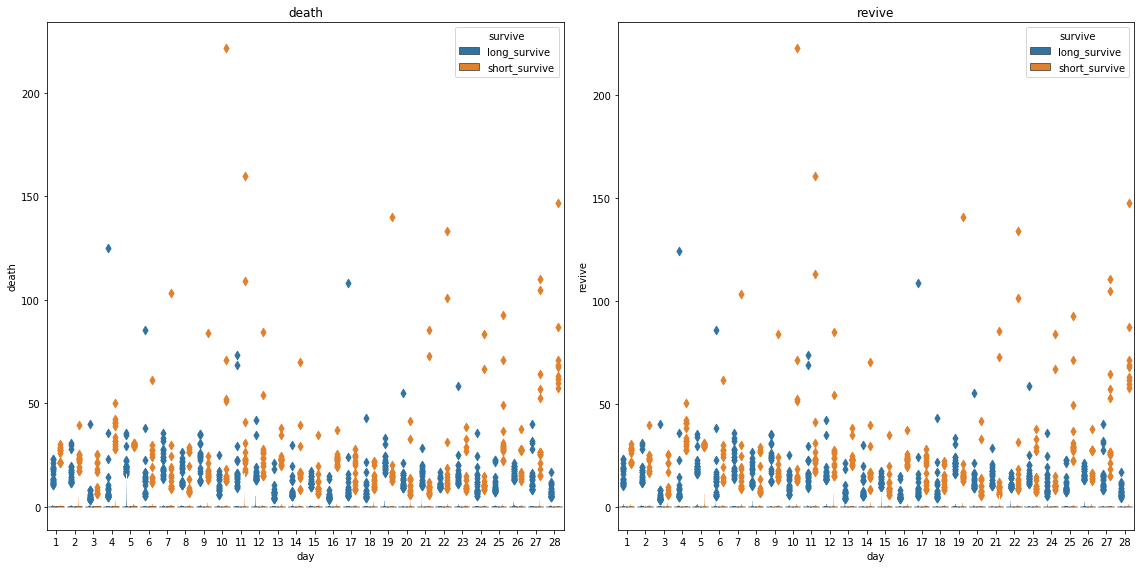

In [0]:
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
sns.boxenplot(x='day', y= 'death', hue='survive', data=activity_summary_label)
plt.title('death')

plt.subplot(1,2,2)
sns.boxenplot(x='day', y= 'revive', hue='survive', data=activity_summary_label)
plt.title('revive')

plt.tight_layout()
plt.show()

In [0]:
pd.DataFrame(np.where(activity_summary_label['death'] == activity_summary_label['revive'], 'd_to_r', 'no_r'), columns=['dr']).dr.value_counts()

d_to_r    781163
no_r      168195
Name: dr, dtype: int64

- 죽으면 대체로 부활한다 (781163/168195 = 4.644388953298255)

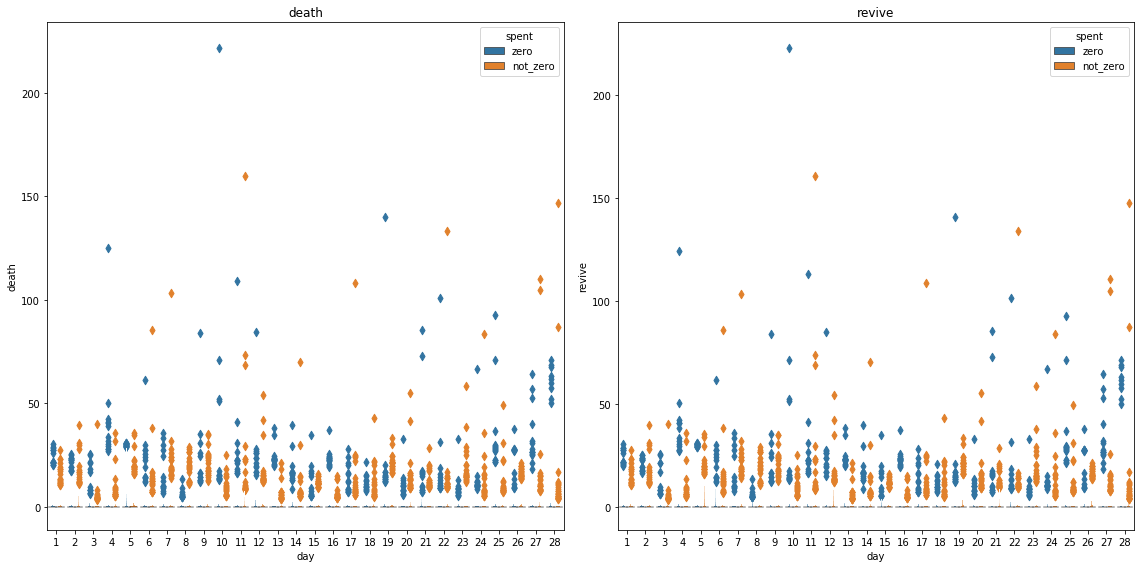

In [0]:
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
sns.boxenplot(x='day', y= 'death', hue='spent', data=activity_summary_label)
plt.title('death')

plt.subplot(1,2,2)
sns.boxenplot(x='day', y= 'revive', hue='spent', data=activity_summary_label)
plt.title('revive')

plt.tight_layout()
plt.show()

In [0]:
df = pd.DataFrame({'day':activity_summary_label['day'], 'dr':np.where(activity_summary_label['death'] == activity_summary_label['revive'], 'd_to_r', 'no_r'), 'survive':activity_summary_label['survive'],
                  'spent':activity_summary_label['spent']})

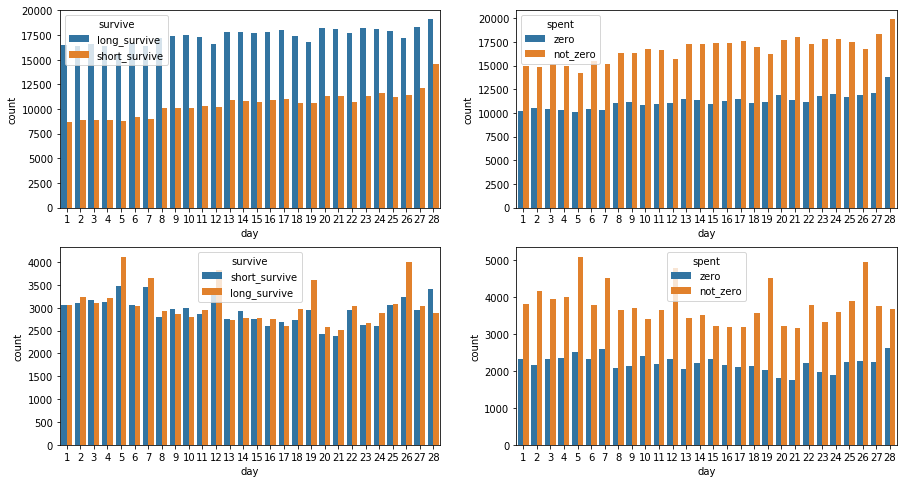

In [0]:
plt.subplot(2,2,1)
sns.countplot(x='day', hue='survive', data=df[df['dr'] == 'd_to_r'])

plt.subplot(2,2,3)
sns.countplot(x='day', hue='survive', data=df[df['dr'] == 'no_r'])

plt.subplot(2,2,2)
sns.countplot(x='day', hue='spent', data=df[df['dr'] == 'd_to_r'])

plt.subplot(2,2,4)
sns.countplot(x='day', hue='spent', data=df[df['dr'] == 'no_r'])

plt.show()

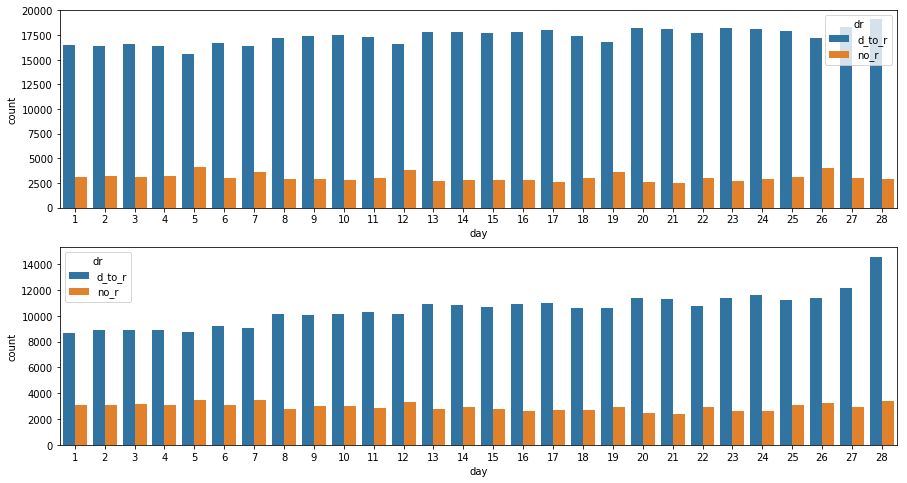

In [0]:
plt.subplot(2,1,1)
sns.countplot(x='day', hue='dr', data=df[df['survive'] == 'long_survive'])

plt.subplot(2,1,2)
sns.countplot(x='day', hue='dr', data=df[df['survive'] == 'short_survive'])
plt.show()

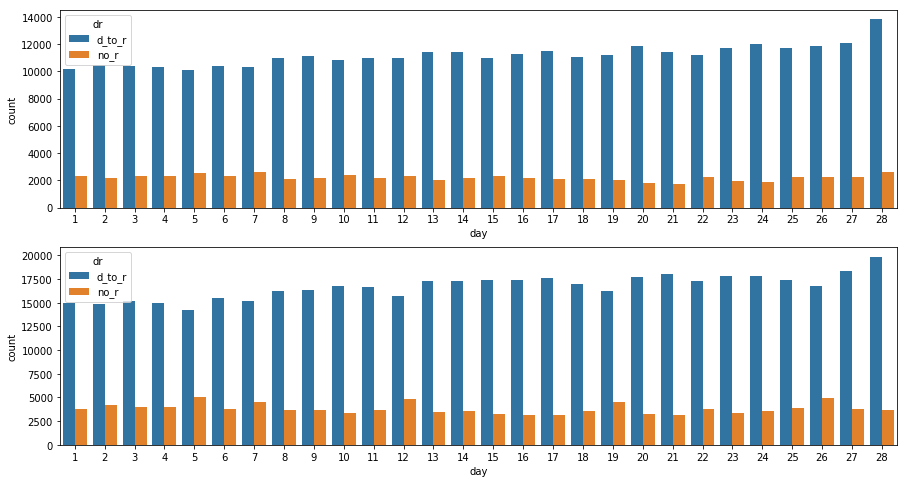

In [0]:
plt.subplot(2,1,1)
sns.countplot(x='day', hue='dr', data=df[df['spent'] == 'zero'])

plt.subplot(2,1,2)
sns.countplot(x='day', hue='dr', data=df[df['spent'] == 'not_zero'])
plt.show()

- 부활 잘 하는 사람들 중에는 이탈 비율이 낮지만, 부활 안 하는 사람들은 이탈자 비율이 미이탈자와 비슷하다

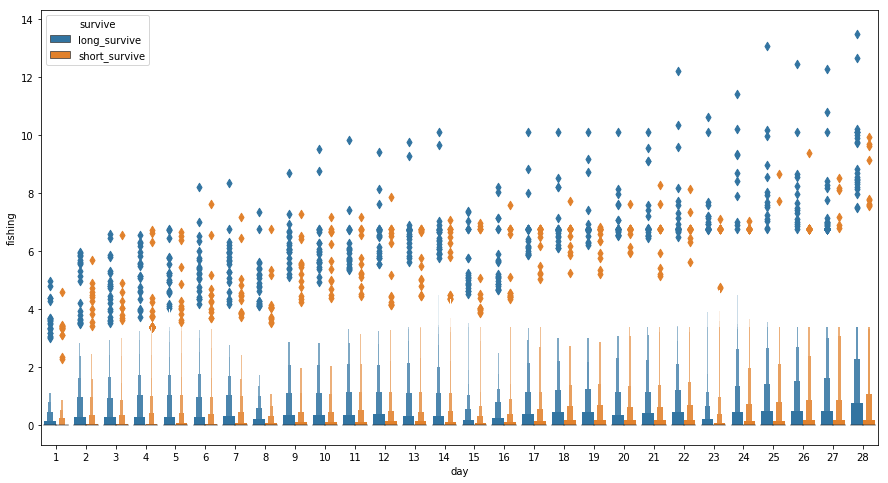

In [0]:
sns.boxenplot(x='day', y= 'fishing', hue='survive', data=activity_summary_label)
plt.show()

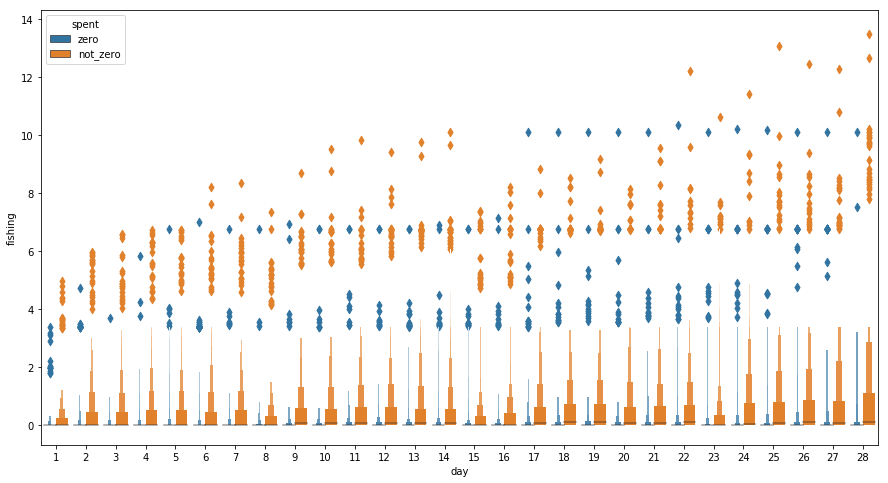

In [0]:
sns.boxenplot(x='day', y= 'fishing', hue='spent', data=activity_summary_label)
plt.show()

- 낚시는 생존 집단이 아닌 집단보다 조금 더 한다
- 낚시는 돈 쓴 집단이 아닌 집단보다 많이 한다

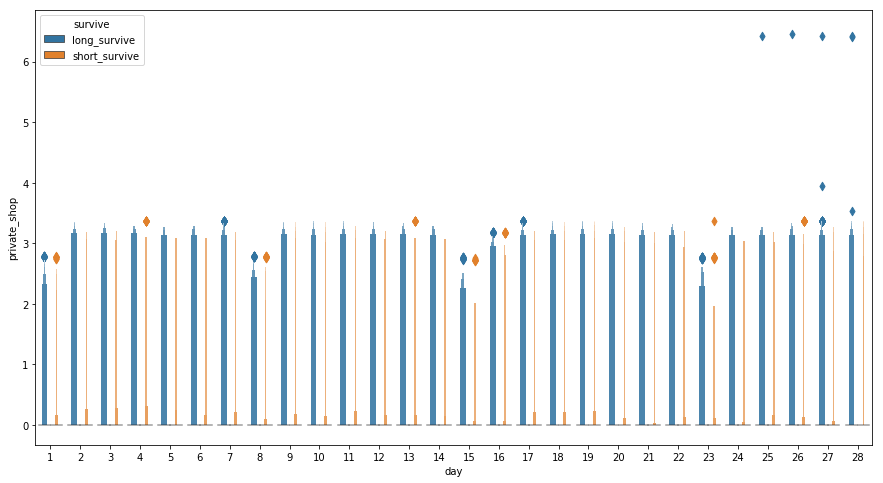

In [0]:
sns.boxenplot(x='day', y= 'private_shop', hue='survive', data=activity_summary_label)
plt.show()

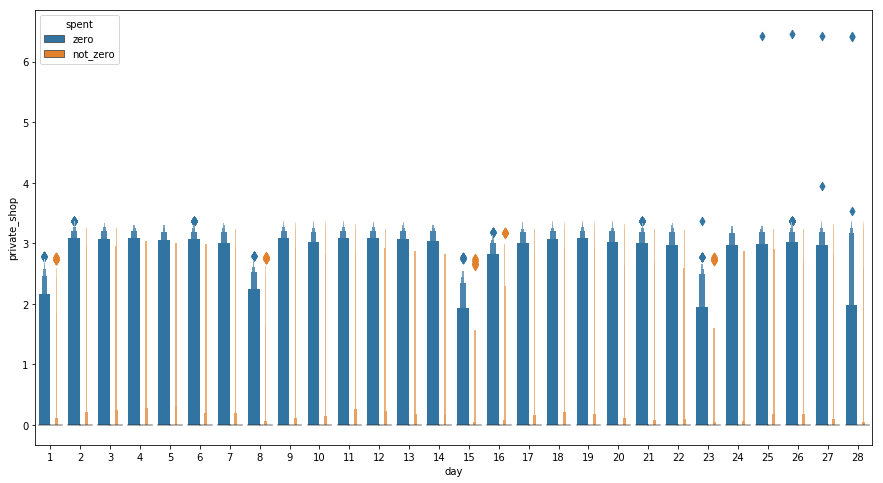

In [0]:
sns.boxenplot(x='day', y= 'private_shop', hue='spent', data=activity_summary_label)
plt.show()

- **개인상점**은 생존 집단이 아닌 집단보다 많이 한다
- **개인상점**은 돈 안 쓴 집단이 돈 쓴 집단보다 많이 한다

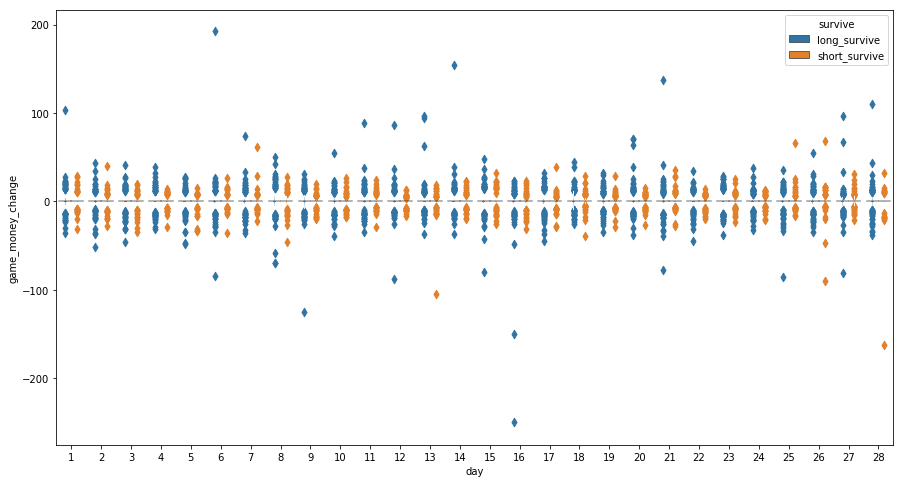

In [0]:
sns.boxenplot(x='day', y= 'game_money_change', hue='survive', data=activity_summary_label)
plt.show()

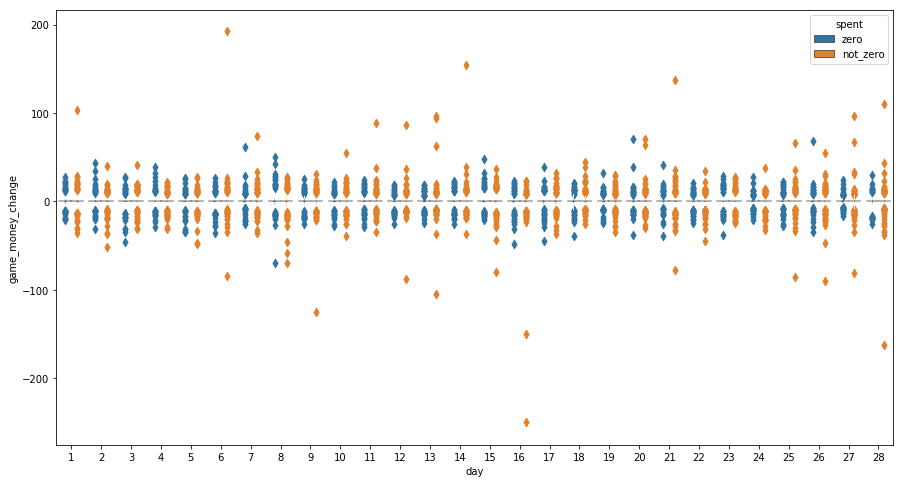

In [0]:
sns.boxenplot(x='day', y= 'game_money_change', hue='spent', data=activity_summary_label)
plt.show()

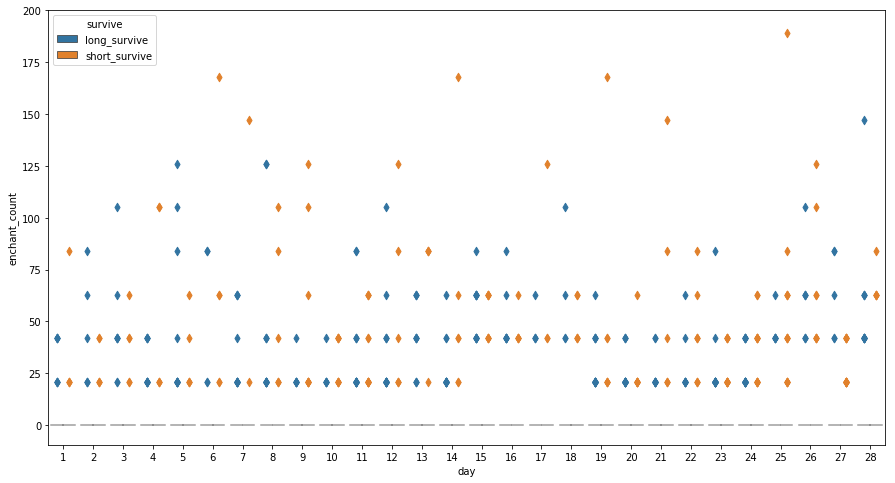

In [0]:
sns.boxenplot(x='day', y= 'enchant_count', hue='survive', data=activity_summary_label)
plt.show()

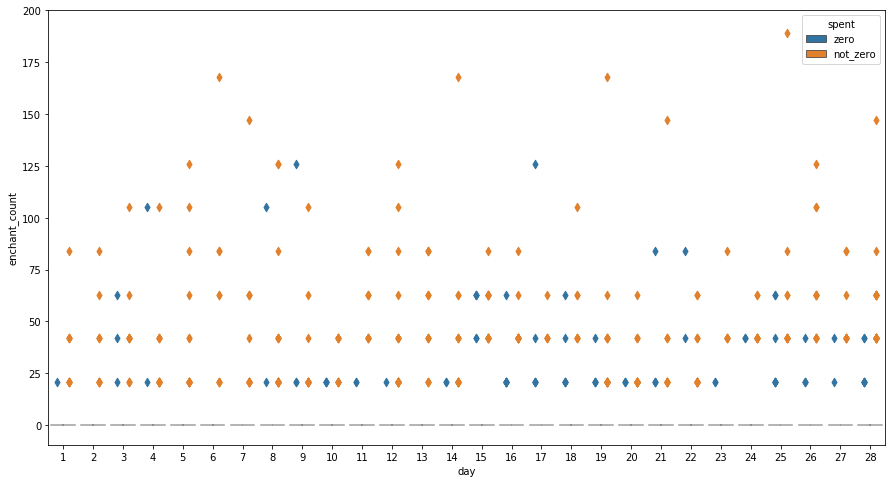

In [0]:
sns.boxenplot(x='day', y= 'enchant_count', hue='spent', data=activity_summary_label)
plt.show()

- enchant는 대체로 안하는 편
- 그나마 많이 한 애들은 돈 쓴 애들이 많다

# Train, Test 1/2 비교

In [0]:
path = '/gdrive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'test'),'\n')

['test1_payment.csv', 'test2_payment.csv', 'test1_activity.csv', 'test1_combat.csv', 'test1_pledge.csv', 'test1_trade.csv', 'test2_activity.csv', 'test2_combat.csv', 'test2_pledge.csv', 'test2_trade.csv'] 



In [0]:
test1_activity = pd.read_csv(path+'test/'+'test1_activity.csv')
test2_activity = pd.read_csv(path+'test/'+'test2_activity.csv')

In [0]:
test1_activity.shape

(709928, 17)

In [0]:
test1_activity.head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,31609,363408,aa,0.482175,0.412287,0.005781,0.000000,0.001301,0,0.0,0.0,0.0,0.0,0.0,-0.121090,0.0
1,1,95442,159538,aa,1.343536,0.264945,0.004106,0.002447,0.000868,1,0.0,0.0,0.0,0.0,0.0,0.346029,0.0
2,1,95442,284220,aa,0.079582,0.006083,0.000000,0.035977,0.000000,0,0.0,0.0,0.0,0.0,0.0,-0.000160,0.0
3,1,95442,178996,aa,0.067879,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,95442,183718,aa,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## day 정보 유지

In [0]:
activity_summary_test1 = test1_activity.drop(['char_id', 'server'], axis=1).groupby(['acc_id', 'day']).sum().reset_index()
activity_summary_test1.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,11,0.063198,0.037173,0.021801,0.0,0.109014,0,0.000000,0.000000,0.0,0.0,0.0,0.000006,0.0
1,7,12,0.105329,0.049677,0.078689,0.0,0.304077,0,0.245883,0.247337,0.0,0.0,0.0,0.000078,0.0
2,7,13,0.126395,0.061167,1.222311,0.0,7.698160,0,0.000000,0.000000,0.0,0.0,0.0,0.000053,0.0
3,7,15,0.070220,0.032442,0.796571,0.0,4.618896,0,0.000000,0.000000,0.0,0.0,0.0,-0.000011,0.0
4,7,18,0.018725,0.009124,0.187266,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000007,0.0


In [0]:
test2_activity.shape

(761888, 17)

In [0]:
test2_activity.head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,43337,22671,aa,0.273857,0.185867,0.006453,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.00000,0.0,0.004180,0.0
1,1,16892,260714,aa,0.381527,0.152073,0.007430,0.000000,0.001735,0,0.245883,0.000000,0.000000,0.00000,0.0,-0.014307,0.0
2,1,13584,143979,aa,0.840295,0.360244,0.007856,0.010651,0.000000,1,0.245883,0.247337,15.948733,0.09663,0.0,-0.015057,0.0
3,1,13584,382845,aa,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0
4,1,13584,364142,aa,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0


In [0]:
activity_summary_test2 = test2_activity.drop(['char_id', 'server'], axis=1).groupby(['acc_id', 'day']).sum().reset_index()
activity_summary_test2.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,1,3.370544,2.259468,0.019597,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.000266,0.0
1,1,2,3.344796,2.280420,0.019898,0.0,0.0,0,0.245883,0.0,0.0,0.0,0.0,-0.000230,0.0
2,1,3,3.344796,2.241557,0.019653,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.000154,0.0
3,1,4,3.370544,2.215873,0.019488,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,-0.000105,0.0
4,1,5,3.363522,2.290896,0.020145,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.000059,0.0


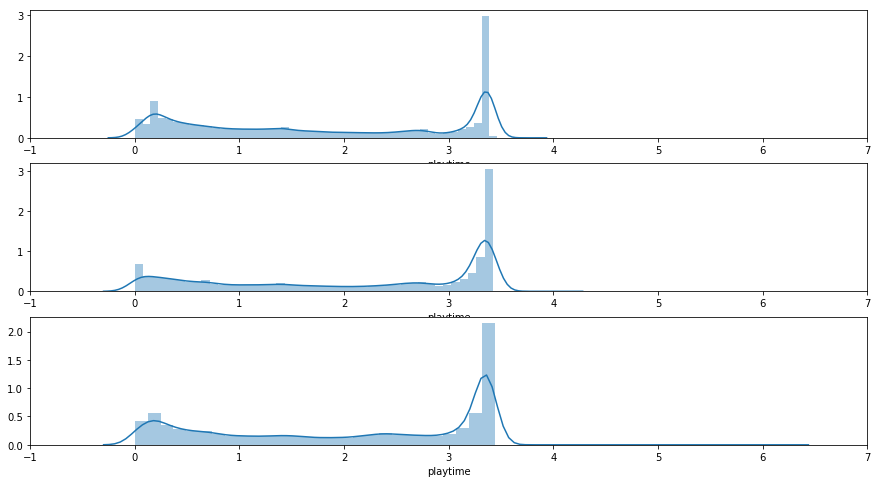

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_summary_label['playtime'])
plt.xlim(-1, 7)

plt.subplot(3,1,2)
sns.distplot(activity_summary_test1['playtime'])
plt.xlim(-1, 7)

plt.subplot(3,1,3)
sns.distplot(activity_summary_test2['playtime'])
plt.xlim(-1, 7)

plt.show()

- test2 때 하드하게 한 애들이 아주 조금 더 있었다
- 3시간 이상 하는 유저가 많다

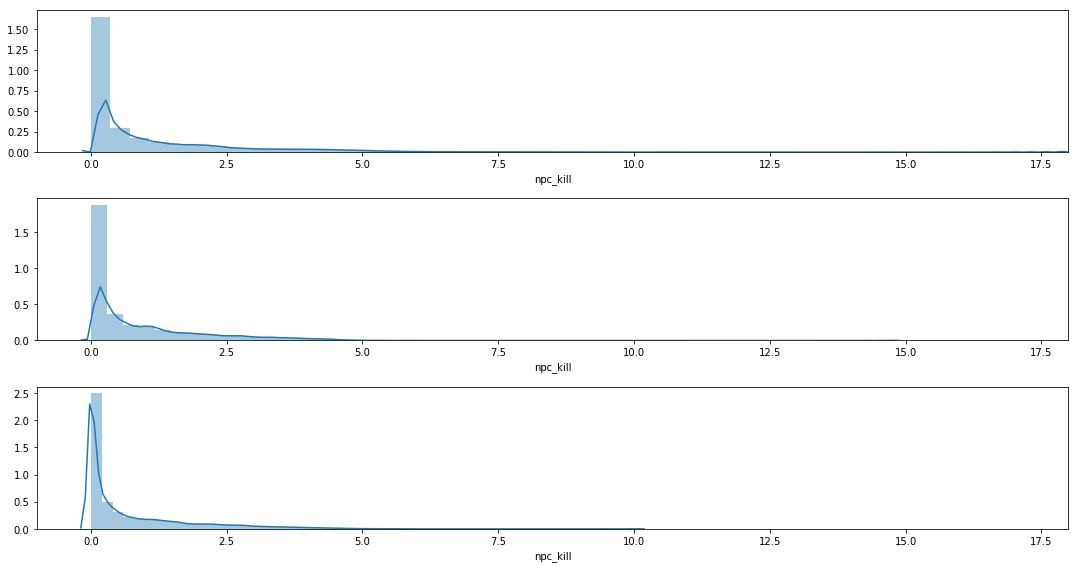

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_summary_label['npc_kill'])
plt.xlim(-1, 18)

plt.subplot(3,1,2)
sns.distplot(activity_summary_test1['npc_kill'])
plt.xlim(-1, 18)

plt.subplot(3,1,3)
sns.distplot(activity_summary_test2['npc_kill'])
plt.xlim(-1, 18)

plt.tight_layout()
plt.show()

- train 기간 때 npc킬 좀 더 하드하게 한 애들이 있었다
- test2 기간 때 npc 잘 안 죽임

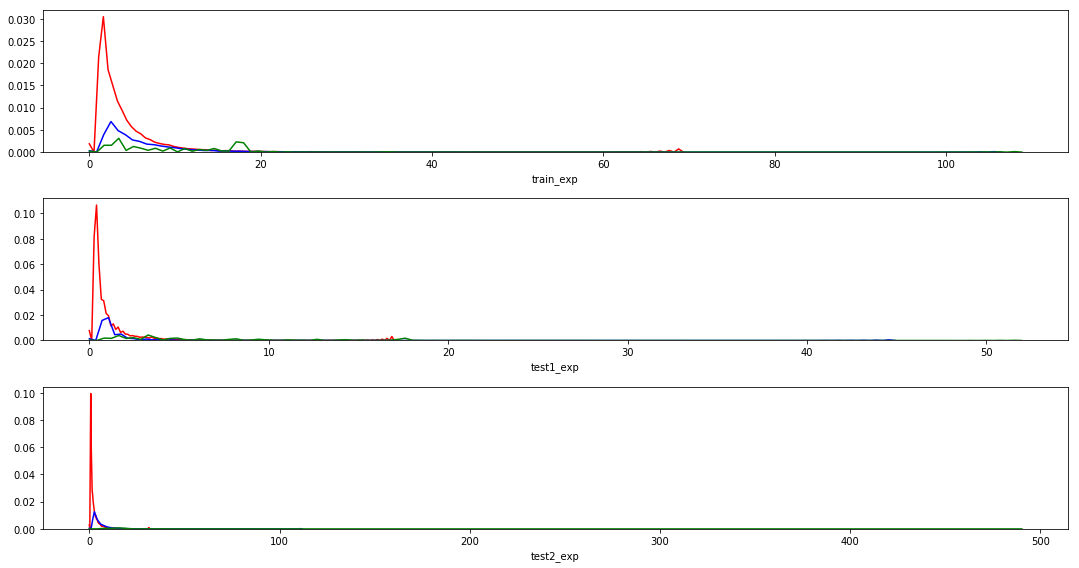

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_summary_label['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_label['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_label['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('train_exp')
#plt.xlim(-1, 18)

plt.subplot(3,1,2)
sns.distplot(activity_summary_test1['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_test1['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_test1['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test1_exp')
#plt.xlim(-1, 18)

plt.subplot(3,1,3)
sns.distplot(activity_summary_test2['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_test2['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_test2['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test2_exp')
#plt.xlim(-1, 18)

plt.tight_layout()
plt.show()

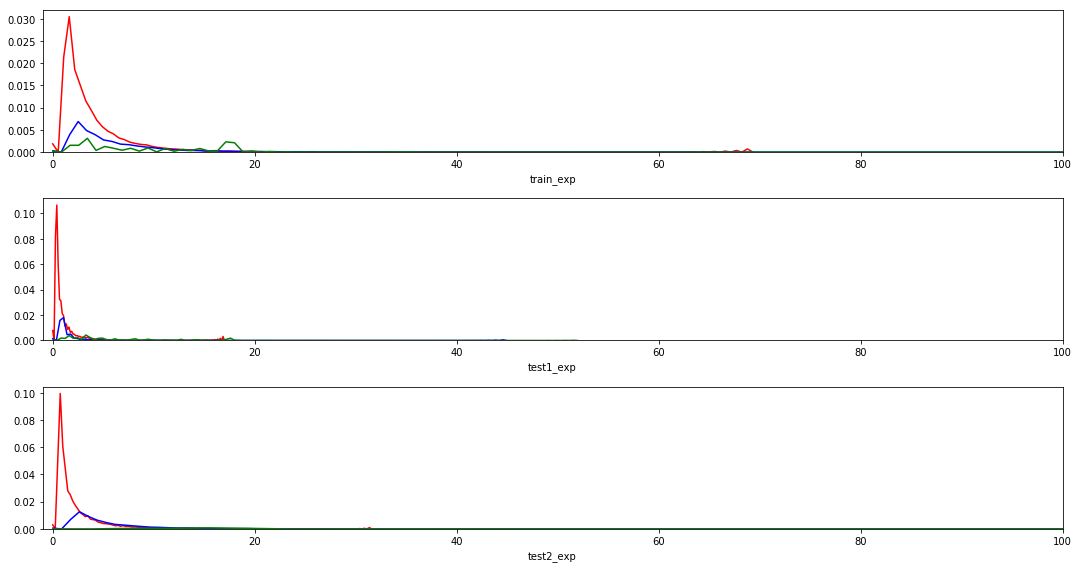

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_summary_label['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_label['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_label['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('train_exp')
plt.xlim(-1, 100)

plt.subplot(3,1,2)
sns.distplot(activity_summary_test1['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_test1['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_test1['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test1_exp')
plt.xlim(-1, 100)

plt.subplot(3,1,3)
sns.distplot(activity_summary_test2['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_summary_test2['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_summary_test2['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test2_exp')
plt.xlim(-1, 100)

plt.tight_layout()
plt.show()

- train 기간 때 경험치 비교적 많이 얻었다
- 대체로 아웃라이어들 때문에 차이가 나지 비슷한 편
- test2 기간 하루 퀘스트 경험치 500 넘는 경우도 있음

## 기간 전체 합쳐서

In [0]:
activity_sum_train = activity_summary_label.groupby('acc_id').sum().reset_index()
activity_sum_train.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survival_time,amount_spent
0,2,406,91.533663,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,84.900753,-0.008746,0.0,1792,0.000000
1,5,218,6.116132,3.236452,2.155434,0.695285,0.111055,9,0.245883,0.247337,0.0,3.442909,0.000000,0.145146,0.0,600,0.000000
2,8,406,18.797802,31.172609,31.489136,0.000000,1.561055,2,91.960416,92.504000,0.0,4.807823,0.000000,0.020353,0.0,1792,0.568681
3,17,406,28.464708,30.456852,9.255848,8.823094,2.322365,21,1.721184,1.731358,0.0,13.990954,0.000000,-0.027696,0.0,1792,1.977981
4,20,387,25.588043,34.100184,0.274902,0.080060,0.083483,8,0.983534,0.989348,0.0,4.295766,2.917510,-0.370192,0.0,1728,1.407692


- acc_id: 2는 경험치는 하나도 안 늘리고 상점만 운영했다. 이런 식으로 다양한 유형의 사람들이 있을 것 같다

In [0]:
activity_sum_test1 = activity_summary_test1.groupby('acc_id').sum().reset_index()
activity_sum_test1.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,194,1.252251,0.719474,8.624290,0.000000,34.556743,0,0.737650,0.494674,0.0,0.000000,0.000000,0.000972,0.0
1,15,406,85.705431,18.207875,0.630317,0.000000,0.000000,0,7.868271,6.183422,0.0,0.000000,0.000000,-0.000240,0.0
2,16,76,0.081923,0.000000,0.000000,0.000000,0.100846,0,0.000000,0.000000,0.0,0.000000,0.000000,0.033401,0.0
3,18,286,40.008820,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,36.945877,0.143130,0.0
4,19,406,84.139533,79.866399,0.271431,0.954236,0.007157,2,0.737650,0.494674,0.0,37.465503,0.000000,0.227807,0.0


In [0]:
activity_sum_test2 = activity_summary_test2.groupby('acc_id').sum().reset_index()
activity_sum_test2.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,406,88.551668,58.285882,0.512386,0.000000,0.000000,0,2.704718,0.000000,0.0,0.000000,0.0,0.000116,0.0
1,3,292,2.694094,0.092596,0.010214,0.000000,0.078912,2,0.000000,0.000000,0.0,1.025441,0.0,0.019400,0.0
2,9,83,0.081923,0.015883,0.005888,0.000000,0.066681,0,0.000000,0.000000,0.0,0.000000,0.0,0.028409,0.0
3,14,270,6.558516,0.215944,0.033683,0.000837,0.006073,4,0.983534,0.989348,0.0,0.526569,0.0,0.008024,0.0
4,26,406,31.816526,3.774791,0.428995,0.009611,0.000868,5,29.506016,29.680428,0.0,83.157199,0.0,-0.020933,0.0


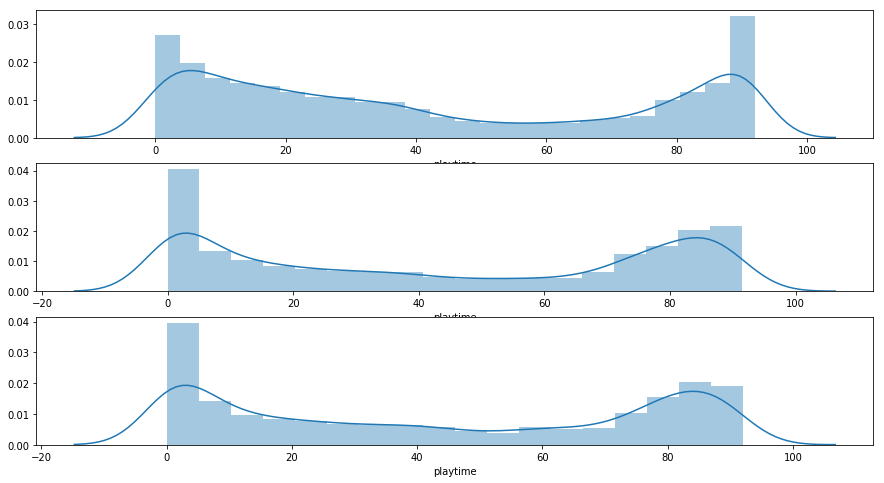

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_sum_train['playtime'])

plt.subplot(3,1,2)
sns.distplot(activity_sum_test1['playtime'])

plt.subplot(3,1,3)
sns.distplot(activity_sum_test2['playtime'])

plt.show()

In [0]:
print(activity_sum_train['playtime'].max())
print(activity_sum_test1['playtime'].max())
print(activity_sum_test2['playtime'].max())
print(activity_sum_train['playtime'].min())
print(activity_sum_test1['playtime'].min())
print(activity_sum_test2['playtime'].min())

91.89412381960474
91.46344325967586
92.03924444305903
0.002340655217004705
0.002340655217004705
0.002340655217004705


- train 기간 때 playtime 합이 큰 사람들 많았다.
- test1, test2는 비슷한 경향성
- playtime합의 최대치는 92정도 (?)
- playtime합의 최소치는 0.002340655217004705. 정규화된 수치라는 걸 알 수 있음

In [0]:
min_players_train = activity_sum_train[activity_sum_train['playtime']==0.002340655217004705]['acc_id'].values
min_players_test1 = activity_sum_test1[activity_sum_test1['playtime']==0.002340655217004705]['acc_id'].values
min_players_test2 = activity_sum_test2[activity_sum_test2['playtime']==0.002340655217004705]['acc_id'].values

In [0]:
activity_summary_label[activity_summary_label['acc_id'].isin(min_players_train)].sort_values(by=['acc_id', 'day'])

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survival_time,amount_spent,survive,spent
284,54,5,0.304285,0.081444,0.072160,0.000000,0.067444,0,0.000000,0.000000,0.0,0.000000,0.0,0.001380,0.0,50,0.059060,short_survive,not_zero
285,54,6,2.055095,0.569091,6.611427,0.000000,3.140849,0,0.245883,0.247337,0.0,0.000000,0.0,-0.000134,0.0,50,0.059060,short_survive,not_zero
286,54,8,1.411415,0.000000,0.000000,32.993128,5.003804,0,0.245883,0.247337,0.0,0.000000,0.0,0.001908,0.0,50,0.059060,short_survive,not_zero
287,54,10,1.418437,0.000000,0.000000,26.357887,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.003900,0.0,50,0.059060,short_survive,not_zero
288,54,11,0.072560,0.000000,0.000000,1.222726,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000142,0.0,50,0.059060,short_survive,not_zero
289,54,12,2.677710,0.000000,0.000000,28.145484,0.000000,0,0.491767,0.494674,0.0,0.000000,0.0,-0.006533,0.0,50,0.059060,short_survive,not_zero
290,54,13,0.648361,0.000000,0.000000,8.169195,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.001360,0.0,50,0.059060,short_survive,not_zero
291,54,14,2.153403,0.000000,0.000000,14.907608,0.000000,0,0.737650,0.742011,0.0,0.000000,0.0,0.009321,0.0,50,0.059060,short_survive,not_zero
292,54,15,0.159165,0.000000,0.000000,1.739538,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,-0.010718,0.0,50,0.059060,short_survive,not_zero
293,54,16,3.087324,0.000000,0.000000,18.334875,0.038491,0,2.458835,2.473369,0.0,0.000000,0.0,0.000160,0.0,50,0.059060,short_survive,not_zero


In [0]:
activity_summary_label[activity_summary_label['acc_id'].isin(min_players_train)]['survive'].value_counts()

short_survive    202
Name: survive, dtype: int64

In [0]:
activity_summary_test1[activity_summary_test1['acc_id'].isin(min_players_test1)].sort_values(by=['acc_id','day'])

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
319,83,1,0.470472,0.286911,0.006873,0.000000,0.000000,0,0.000000,0.000000,0.0,0.063276,0.000000,0.010430,0.0
320,83,2,0.142780,0.113210,0.003767,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,-0.176700,0.0
321,83,4,0.140439,0.154439,0.005441,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,-0.000514,0.0
322,83,5,0.058516,0.081106,0.003673,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.001963,0.0
323,83,6,0.053835,0.059140,0.003099,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,-0.000853,0.0
324,83,8,0.074901,0.075699,0.003622,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.025105,0.0
325,83,10,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
326,83,11,0.145121,0.180460,0.006141,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.005030,0.0
327,83,13,0.079582,0.096313,0.004088,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.007460,0.0
328,83,14,0.142780,0.152749,0.005319,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.005284,0.0


In [0]:
activity_summary_test2[activity_summary_test2['acc_id'].isin(min_players_test2)].sort_values(by=['acc_id','day'])

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
1087,282,5,0.035110,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,-0.000852,0.0
1088,282,6,0.203637,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,-0.000003,0.0
1089,282,7,0.018725,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1090,282,11,0.011703,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1091,282,12,0.051494,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1092,282,13,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1093,282,14,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1094,282,15,0.035110,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.454550,0.0
1095,282,16,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,-0.454550,0.0
1096,282,26,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


- **playtime의 합이 가장 적은 사람들은 모두 28일에만 활동 기록이 있다**
- NC에서 playtime을 구간별로 자르는 것 같은데, 그 중 가장 작은 것이 0.002340655217004705이고, 28일에만 이만큼 플레이한 기록 있는 유저는 train 기준 모두 이탈했다
- 

In [0]:
activity_sum_train[activity_sum_train['acc_id'].isin(min_players_train)].sort_values(by=['acc_id', 'day'])

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survival_time,amount_spent
12,54,380,30.629814,0.650535,6.683587,193.935551,8.250588,0,10.818872,10.388150,0.000000,0.000000,0.000000,0.001446,0.000000,1100,1.299318
68,219,323,5.184551,2.499067,18.457192,0.000000,0.638564,0,0.491767,0.494674,0.000000,2.106824,0.000000,-0.013498,0.000000,342,0.000000
78,260,210,1.376305,0.760703,0.026675,0.034318,0.013014,0,0.000000,0.000000,0.000000,0.330227,0.000000,-0.146157,0.000000,832,0.116446
85,281,321,10.331652,4.634173,0.114886,0.000000,0.020822,2,1.967068,1.978695,0.000000,1.722839,0.000000,0.024362,0.000000,147,0.000000
95,308,230,5.020705,9.672522,19.227835,0.000000,0.047523,2,0.983534,0.989348,0.000000,1.660890,0.000000,-0.010330,0.000000,896,0.449249
100,327,38,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0.000000
235,785,371,21.386567,3.470983,0.428958,0.000000,0.066805,2,0.245883,0.000000,0.000000,11.959734,0.000000,0.023456,0.000000,26,0.000000
327,1129,258,9.238566,2.609573,20.566306,0.000000,5.090361,4,0.000000,0.000000,0.000000,1.024466,0.000000,0.010485,0.000000,16,11.969471
373,1317,215,7.174108,0.017235,0.004662,0.000000,0.079460,0,0.000000,0.000000,0.000000,2.812960,0.000000,0.001993,0.000000,220,0.212287
390,1361,359,3.199676,2.900540,0.295646,0.000000,0.065070,2,0.491767,0.494674,0.000000,1.269766,0.000000,0.000531,0.000000,1426,0.000000


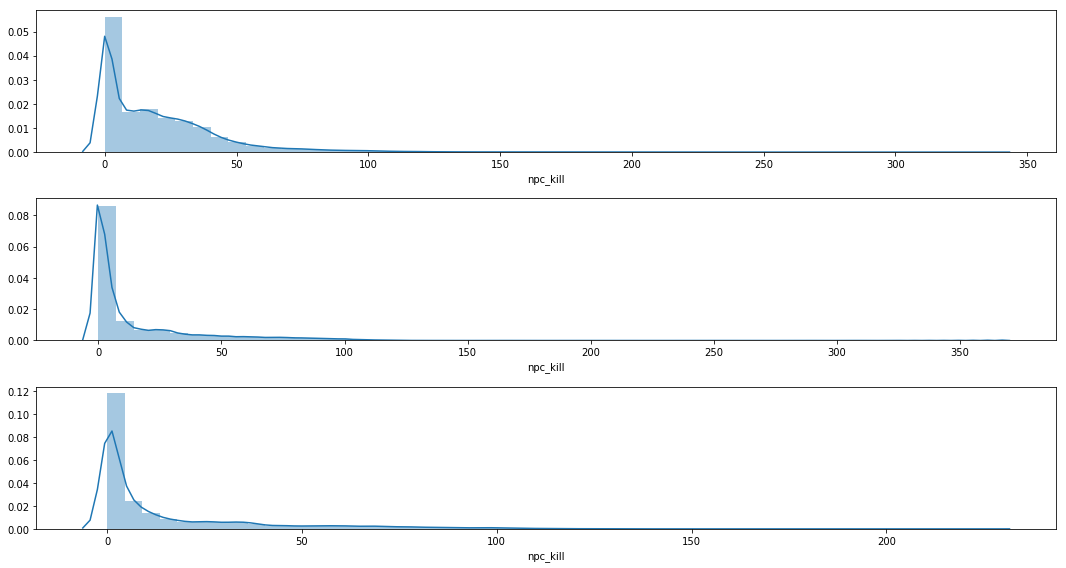

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_sum_train['npc_kill'])

plt.subplot(3,1,2)
sns.distplot(activity_sum_test1['npc_kill'])

plt.subplot(3,1,3)
sns.distplot(activity_sum_test2['npc_kill'])

plt.tight_layout()
plt.show()

- train 기간 때 npc킬 합이 큰 편
- test1, test2 기간 비슷

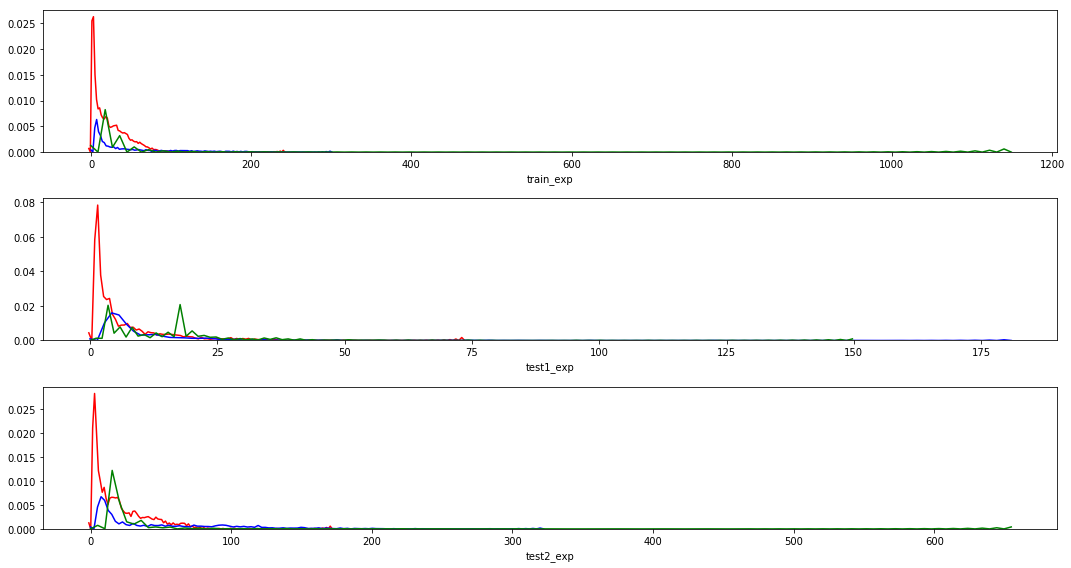

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_sum_train['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_train['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_train['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('train_exp')
#plt.xlim(-1, 18)

plt.subplot(3,1,2)
sns.distplot(activity_sum_test1['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_test1['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_test1['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test1_exp')
#plt.xlim(-1, 18)

plt.subplot(3,1,3)
sns.distplot(activity_sum_test2['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_test2['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_test2['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test2_exp')
#plt.xlim(-1, 18)

plt.tight_layout()
plt.show()

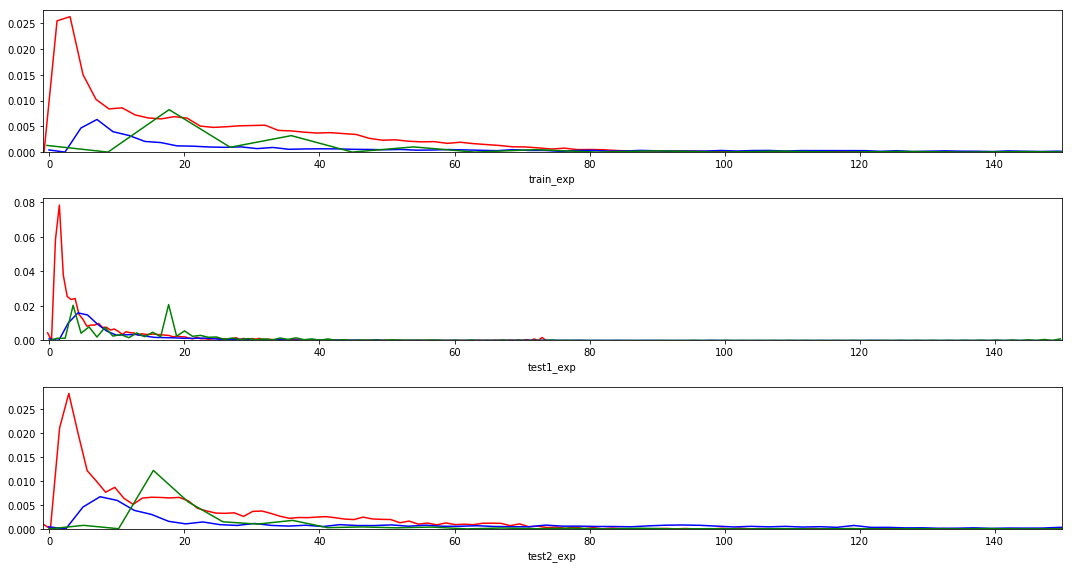

In [0]:
plt.subplot(3,1,1)
sns.distplot(activity_sum_train['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_train['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_train['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('train_exp')
plt.xlim(-1, 150)

plt.subplot(3,1,2)
sns.distplot(activity_sum_test1['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_test1['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_test1['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test1_exp')
plt.xlim(-1, 150)

plt.subplot(3,1,3)
sns.distplot(activity_sum_test2['solo_exp'], kde=True, hist=False, color='r')
sns.distplot(activity_sum_test2['party_exp'], kde=True, hist=False, color='b')
sns.distplot(activity_sum_test2['quest_exp'], kde=True, hist=False, color='g')
plt.xlabel('test2_exp')
plt.xlim(-1, 150)

plt.tight_layout()
plt.show()

- train, test2 기간 때 경험치 비교적 많이 얻었다
- test1이 예외적으로 경험치 획득이 적었다고 보는 게 맞을 듯